In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
from sklearn.metrics import r2_score

In [3]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))


def load_pickle_model(filename):
        # This function loads simulated results, but deletes the particles in order to save memory
        model = load_pickle(filename)
        del model.all_particles
        return model
        

def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Load data

In [4]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/simulation_skeleton.pkl")

In [5]:
model_skeleton["model"] = list(map(load_pickle_model,model_skeleton.outfile))

In [6]:
model_frame = model_skeleton.set_index(["origin","status"])

In [7]:
reference_model = model_frame.loc[("unpermuted","original"),"model"]

In [8]:
models = model_frame.model

In [9]:
!pwd

/home/jakobpp/BayesianGEM/code


### Visualize particle population

In [10]:
model_frame["particle_df"] = load_pickle("../results/permuted_smcabc_res/particle_df.pkl")

In [11]:
unique_origins = model_frame.index.get_level_values("origin").unique()

In [12]:
combined_df = load_pickle("../results/permuted_smcabc_res/combined_particle_df.pkl")

In [13]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

In [285]:
len(reference_model.posterior)

2292

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


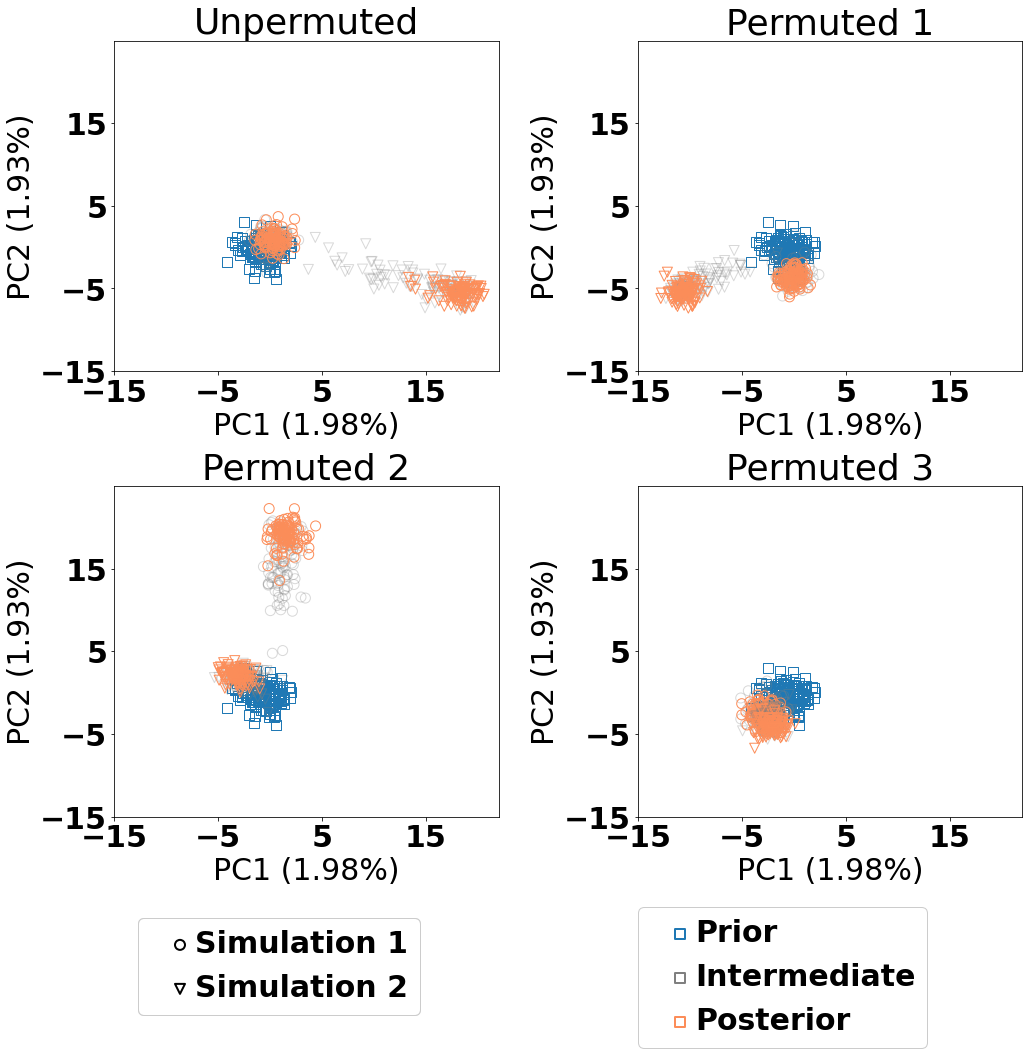

In [14]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-15,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-15,22))
    plt.ylim((-15,25))
    plt.title(proper_names[origin])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc=(-1.3,-.6), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
plt.savefig("../figures/pca.png",dpi=300)
plt.show()

## $R^2$ convergence plots

In [15]:
def r2_on_data(Yobs, simulated_data_one):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in Yobs]
    return np.mean(r2_diff_dbs)

In [16]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [17]:
def plot_convergence_inner(model, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    # r2s_history = np.array([r2_on_data(Yobs, item) if item is not None else 0 for
    #                         item in model.all_simulated_data[:offset*maxiter]])
    r2s_history = -np.array(model.all_distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(model.all_simulated_data):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

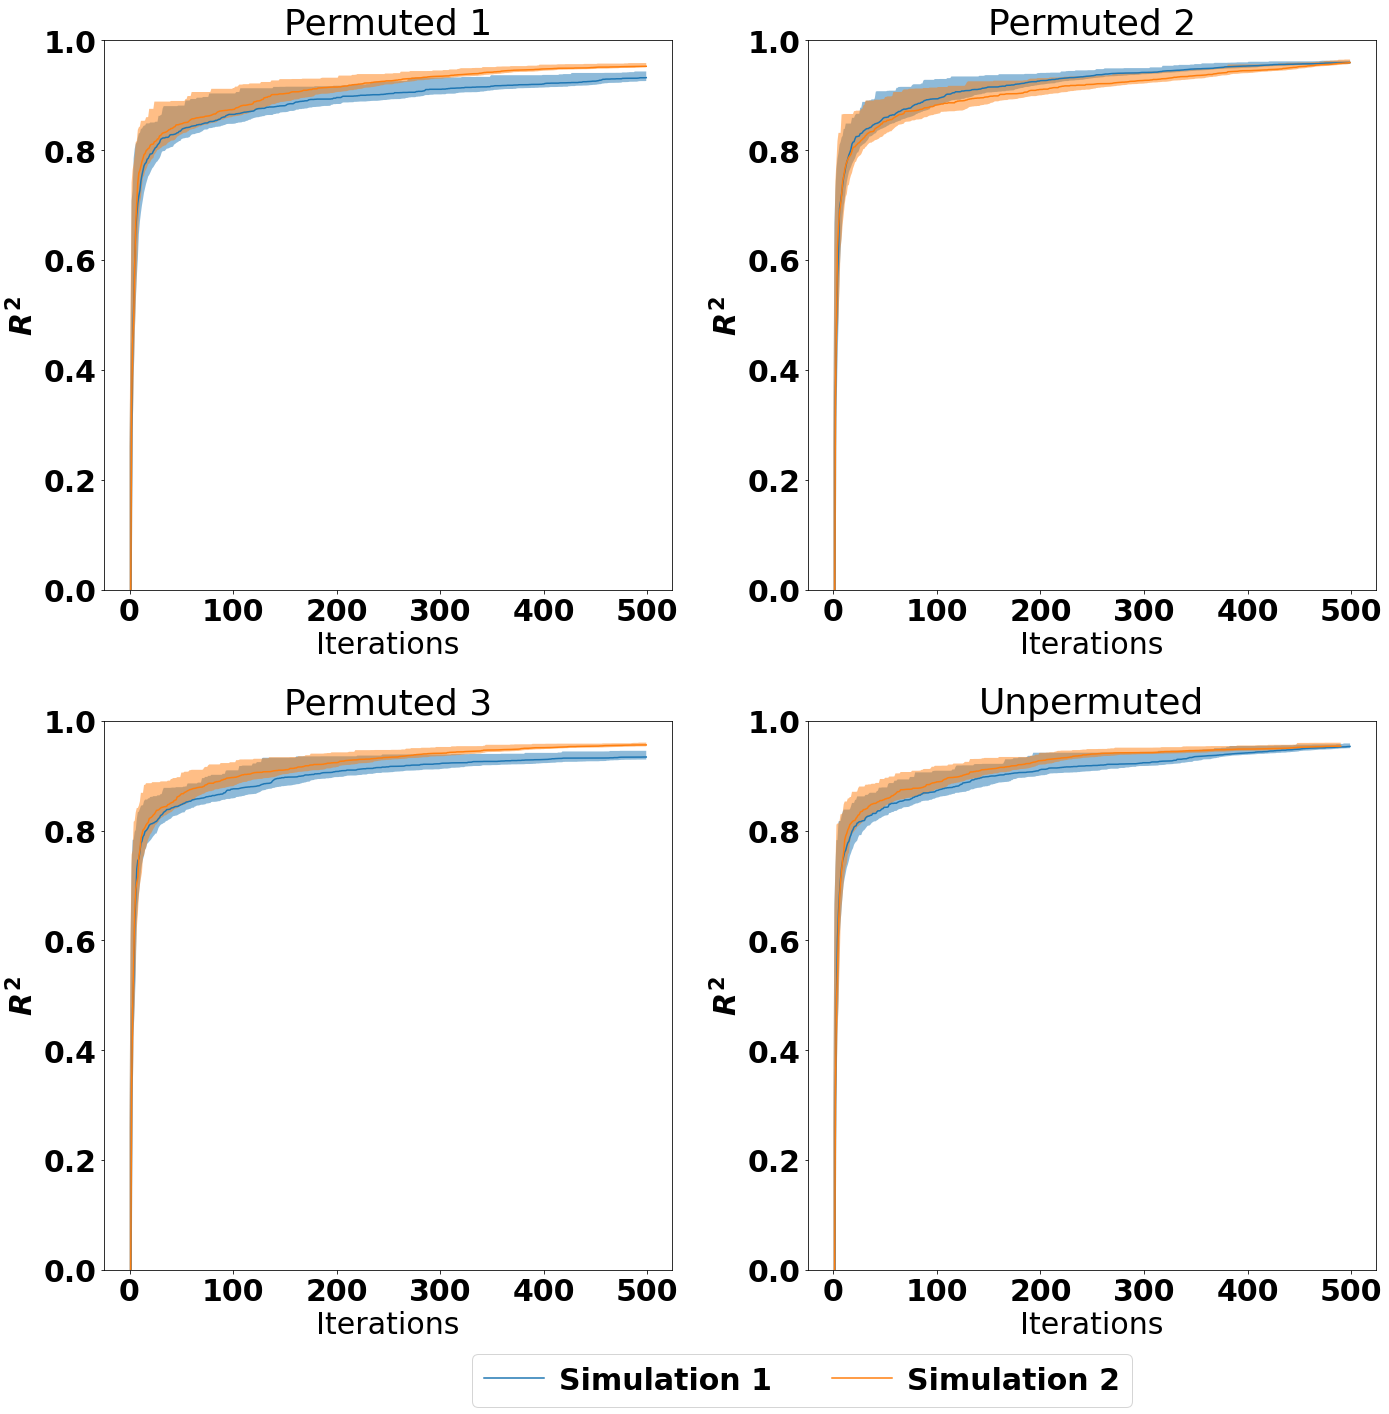

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_model,maxiter, label = 'Simulation 2')
    if i==4:
        handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
    plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
plt.savefig("../figures/R2.pdf")
plt.show()

## Create integrated plot for Unpermuted and Permuted 1

In [19]:
reduced_pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_reduced_ordination.pkl")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(63139,)
(61724,)
(62675,)
(62990,)


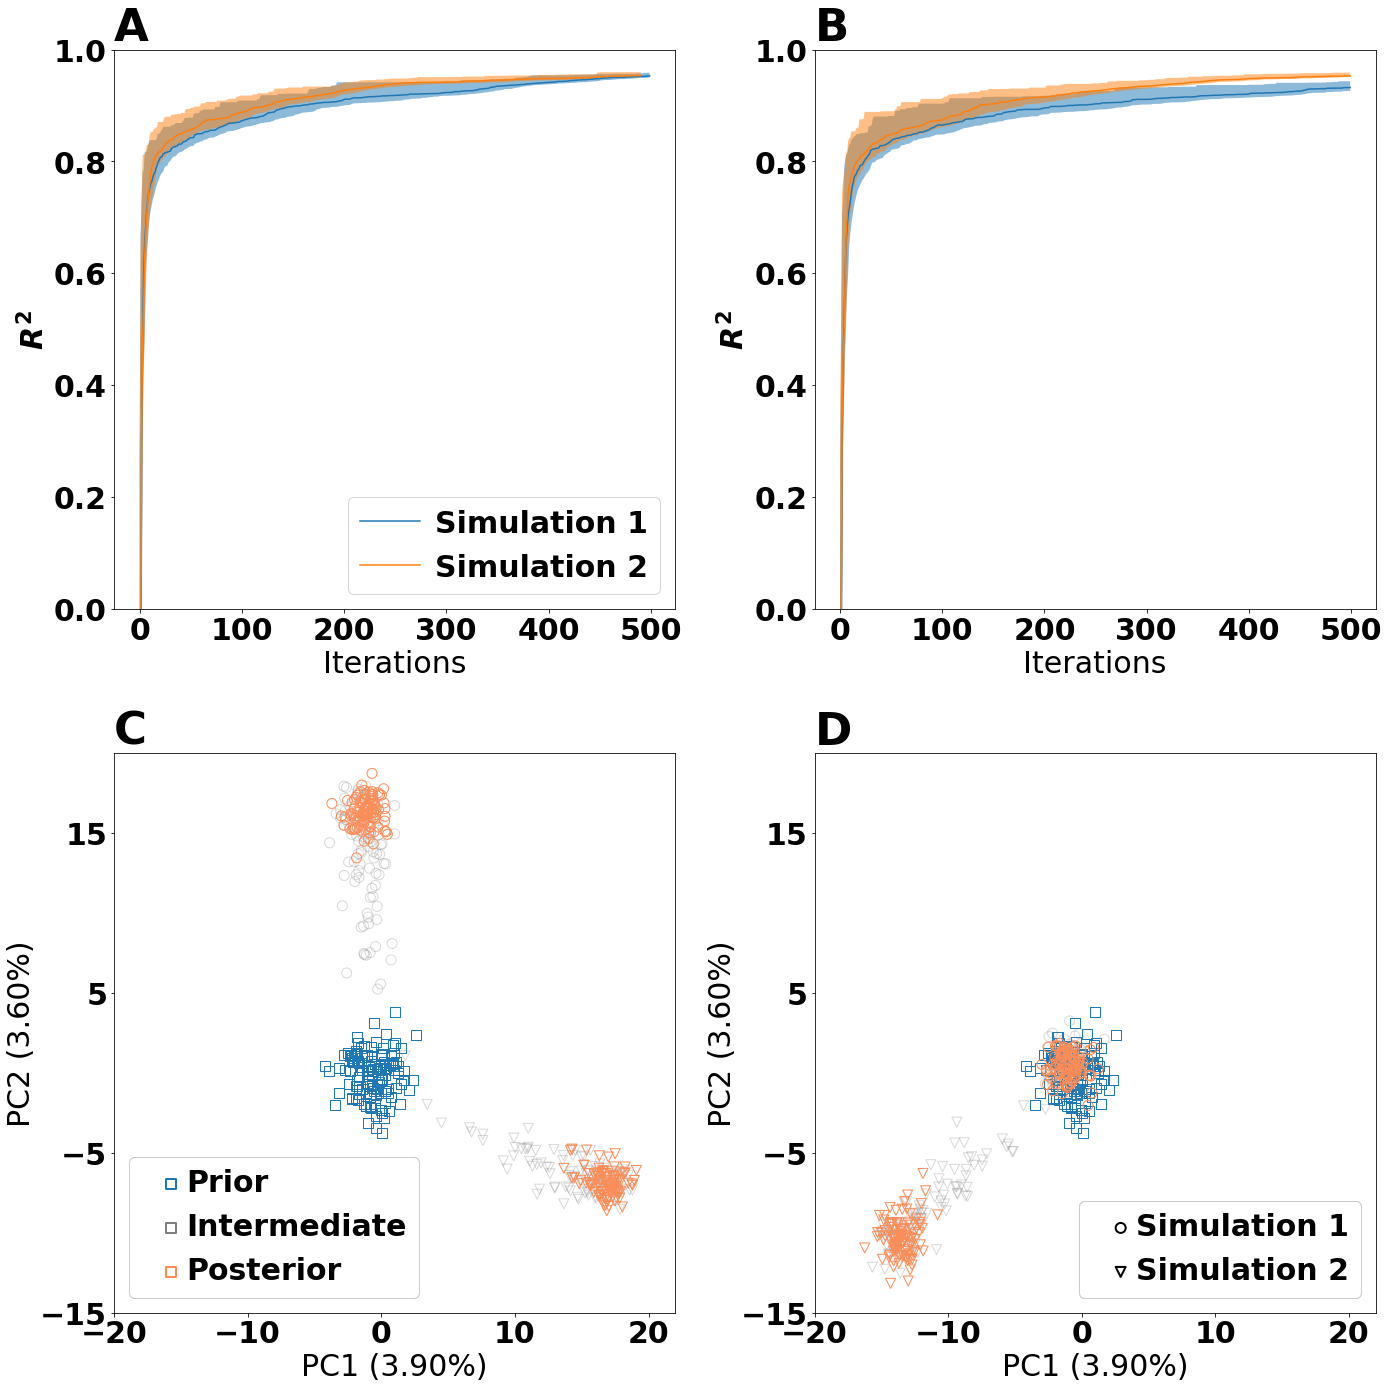

In [20]:
thinning_rng = np.random.default_rng(8049)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
plt.figure(figsize=(20,20))
i=2
for index, series in model_frame.query("origin in ('unpermuted','permuted_0')")["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_model,maxiter, label = 'Simulation 2')
    if i==1:
        plt.legend(loc="lower right",handletextpad=0.5)
        # handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title("A" if index=="unpermuted" else "B",loc="left",fontsize=45,fontweight="bold")
    i -= 1
    plt.tight_layout()
    
PCS, EV = reduced_pca_ordination
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
i=3
for origin in ["unpermuted","permuted_0"]:
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-20,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-20,22))
    plt.ylim((-15,20))
    plt.title("C" if origin=="unpermuted" else "D",loc="left",fontsize=45,fontweight="bold")
    if origin == "unpermuted":
        legend_period = plt.legend(handles_period, all_periods, loc="lower left", framealpha=1, handletextpad=-.5)
        plt.gca().add_artist(legend_period)
    else:
        legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc="lower right", framealpha=1,handletextpad=-.5)
        plt.gca().add_artist(legend_status)
    plt.tight_layout()

plt.savefig("../figures/bayesian_fig.png",dpi=300)
plt.show()

# Results of evolutionary algorithm

In [21]:
evolution_model = load_pickle_model('../results/smcevo_gem_three_conditions_save_all_particles_refined.pkl')

In [22]:
def plot_convergence_and_compare_evolution(model, reference_model, maxiter=100, legend = True):
    plot_convergence_inner(model, generation_size=100, maxiter=maxiter, label = 'Evolutionary')
    plot_convergence_inner(reference_model, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right",handletextpad=0.5)
    plt.tight_layout()

In [23]:
evolution_combined_df = load_pickle("../results/evo_combined_particle_df.pkl")

In [24]:
PCS_evo,EV_evo = load_pickle("../results/evo_pca_full_ordination.pkl")

In [25]:
model = evolution_combined_df.values[:,-1]
period = evolution_combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [26]:
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)

def create_evo_pca_plot(legend = True):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        # It does really only make sense display priors for the Bayesian approach as the evolutionary algorithm generates
        # seed individuals by another method and it thus is most fair to show the Bayesian priors for both of them
        if label == "Bayesian":
            plt.scatter(PCS_evo[this_idxs['Prior'],0],PCS_evo[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none', s=100)
        plt.scatter(PCS_evo[this_idxs["Intermediate"],0],PCS_evo[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(PCS_evo[this_idxs['Posterior'],0],PCS_evo[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel('PC1 ({:.2f}%)'.format(EV_evo[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV_evo[1]*100))
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
    plt.xticks(np.arange(-10,50,10))
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,.1), framealpha=1)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,.1), framealpha=1)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)

[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)


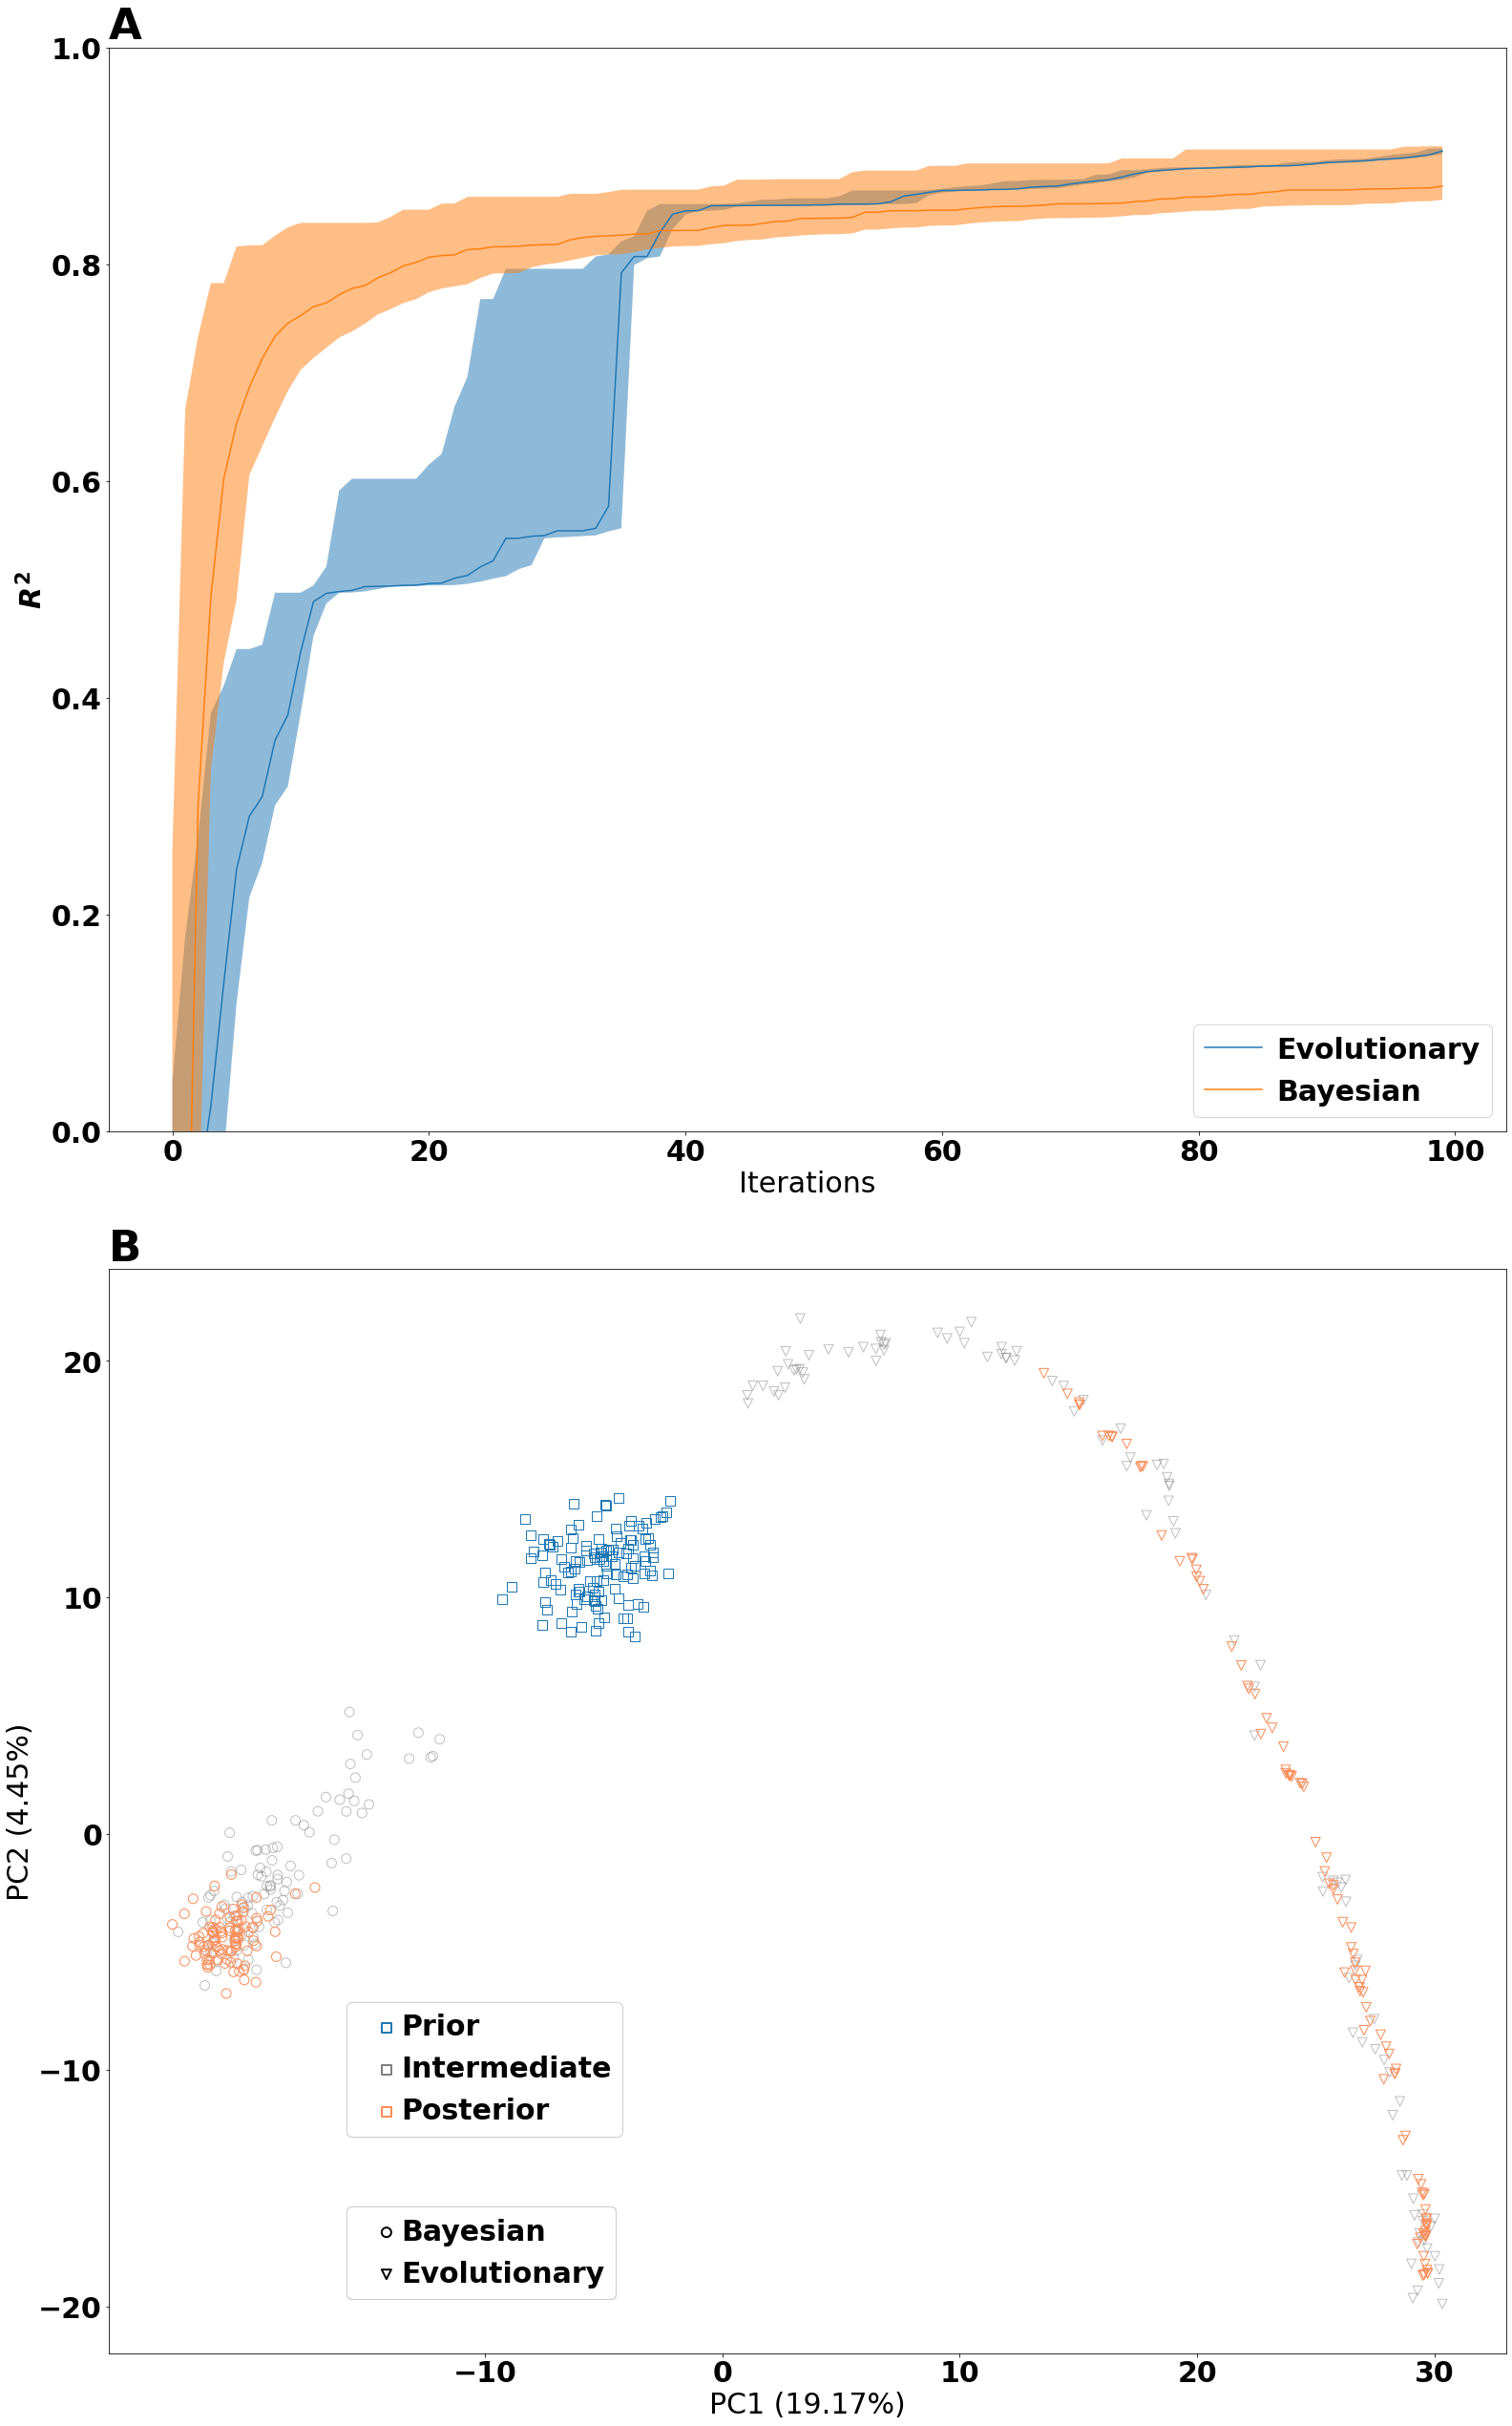

In [27]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(18+5,2*18))
plt.subplot(2,1,1)
plt.title("A",loc="left",fontsize=45,fontweight="bold")
plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = 100)
plt.subplot(2,1,2)
plt.title("B",loc="left",fontsize=45,fontweight="bold")
create_evo_pca_plot(legend = False)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.17,.20), framealpha=1, handletextpad=-0.5)
legend_model = plt.legend(handles_model, labels_status, loc=(.17,.05), framealpha=1,handletextpad=-0.5)
plt.gca().add_artist(legend_period)
plt.gca().add_artist(legend_model)
plt.savefig("../figures/evo_fig.png",dpi=600,bbox_inches = 'tight')


In [28]:
np.median(-np.sort(reference_model.all_distances)[0:99])

0.9531292853589542

In [29]:
np.median(-np.sort(evolution_model.all_distances)[0:99])

0.9511213513744128

In [30]:
tsne_frame = load_pickle("../results/evo_tsne_res/tsne_skeleton.pkl")

In [32]:
tsne_frame["ordination"] = list(map(load_pickle, tsne_frame["outfile"]))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135

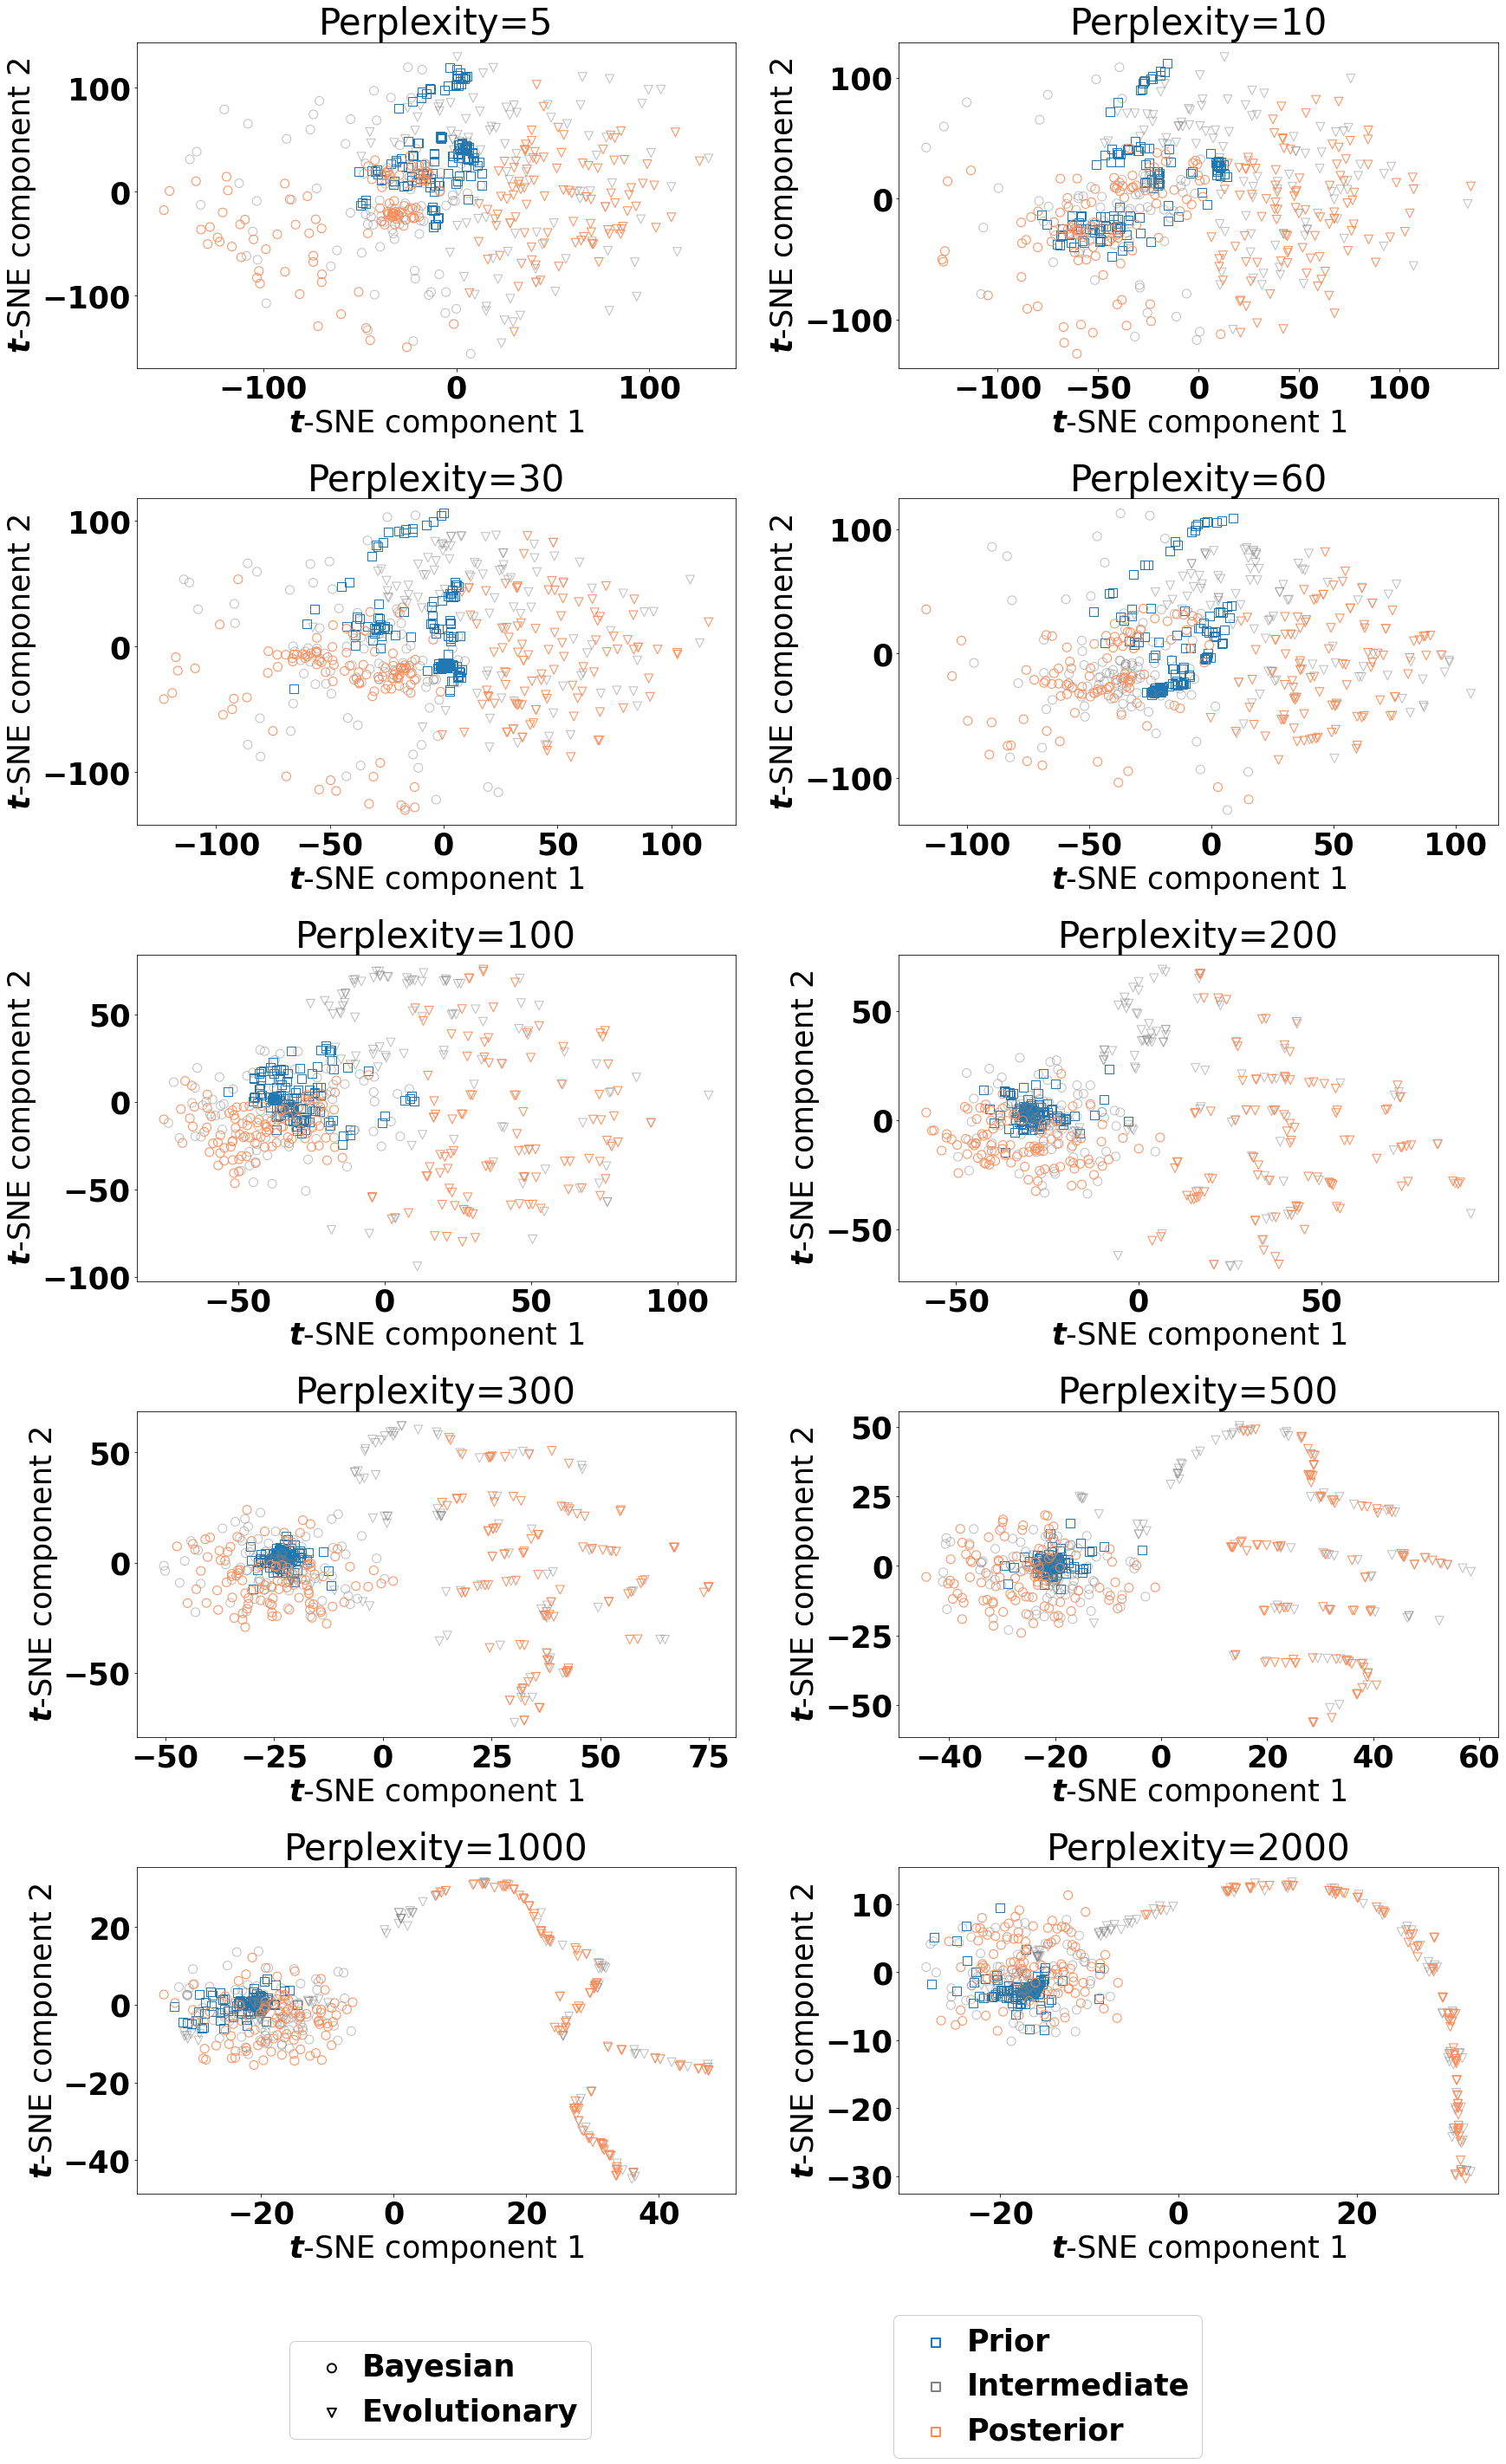

In [34]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 35}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(25,40))
model = evolution_combined_df.values[:,-1]
period = evolution_combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
tsne_thinning_rng = np.random.default_rng(5024)
def create_evo_tsne_plot(tsne_res,legend = True, perplexity = None):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])

        this_idxs["Intermediate"] = tsne_thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = tsne_thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        # It does really only make sense display priors for the Bayesian approach as the evolutionary algorithm generates
        # seed individuals by another method and it thus is most fair to show the Bayesian priors for both of them
        if label == "Bayesian":
            plt.scatter(tsne_res[this_idxs['Prior'],0],tsne_res[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker="s",facecolors='none', s=100)
        plt.scatter(tsne_res[this_idxs["Intermediate"],0],tsne_res[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(tsne_res[this_idxs['Posterior'],0],tsne_res[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel(r'$t$-SNE component 1')
    plt.ylabel(r'$t$-SNE component 2')
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)    
    if perplexity is not None:
        plt.title(f"Perplexity={perplexity}")
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,-0.35), framealpha=1, handletextpad=0)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,-0.3), framealpha=1, handletextpad=0)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.6,-0.16), framealpha=1, handletextpad=0)
legend_model = plt.legend(handles_model, labels_status, loc=(.1,-0.15), framealpha=1, handletextpad=0)

for i, (perplexity,_, ordination) in tsne_frame.iterrows():
    plt.subplot(5,2,i+1)
    create_evo_tsne_plot(ordination,False, perplexity=perplexity)

plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_model)
plt.gcf().subplots_adjust(bottom=.11)
plt.savefig("../figures/evo_tsne.png",dpi=300)
plt.show()

# Effects on pathway level

In [35]:
fva_results = load_pickle("../results/permuted_smcabc_res/fva_at_three_conditions.pkl")

In [36]:
fva_results

origin     status                                           particle  \
0    unpermuted   original  {'O13525_Tm': 331.6638596175288, 'O13525_Topt'...   
1    unpermuted   original  {'O13525_Tm': 320.8117136606959, 'O13525_Topt'...   
2    unpermuted   original  {'O13525_Tm': 325.1114607019797, 'O13525_Topt'...   
3    unpermuted   original  {'O13525_Tm': 328.06580038410783, 'O13525_Topt...   
4    unpermuted   original  {'O13525_Tm': 332.6392528598742, 'O13525_Topt'...   
..          ...        ...                                                ...   
155  permuted_2  replicate  {'O13525_Tm': 330.1971646826934, 'O13525_Topt'...   
156  permuted_2  replicate  {'O13525_Tm': 325.3997674288382, 'O13525_Topt'...   
157  permuted_2  replicate  {'O13525_Tm': 328.0381286580098, 'O13525_Topt'...   
158  permuted_2  replicate  {'O13525_Tm': 335.41589645137054, 'O13525_Topt...   
159  permuted_2  replicate  {'O13525_Tm': 333.0197128453676, 'O13525_Topt'...   

                                               fva_res  
0                    reaction       T   minimum   m...  
1                    reaction       T   minimum   m...  
2                    reaction       T   minimum   m...  
3                    reaction       T   minimum   m...  
4                    reaction       T   minimum   m...  
..                                                 ...  
155                  reaction       T   minimum   m...  
156                  reaction       T   minimum   m...  
157                  reaction       T   minimum   m...  
158                  reaction       T   minimum   m...  
159                  reaction       T   minimum   m...  

[160 rows x 4 columns]

In [37]:
evo_fva_results = load_pickle("../results/evo_fva.pkl")

In [38]:
evo_fva_results

particle  \
0   {'P22438_Topt': 306.3548647753577, 'P46681_dCp...   
1   {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   
2   {'P22438_Topt': 311.8860470422647, 'P46681_dCp...   
3   {'P22438_Topt': 310.6580307638588, 'P46681_dCp...   
4   {'P22438_Topt': 307.82349846062664, 'P46681_dC...   
5   {'P22438_Topt': 311.8883783972634, 'P46681_dCp...   
6   {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   
7   {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   
8   {'P22438_Topt': 310.6017199631328, 'P46681_dCp...   
9   {'P22438_Topt': 311.8916210136895, 'P46681_dCp...   
10  {'P22438_Topt': 306.3561341838288, 'P46681_dCp...   
11  {'P22438_Topt': 311.8860492228331, 'P46681_dCp...   
12  {'P22438_Topt': 311.8868734879213, 'P46681_dCp...   
13  {'P22438_Topt': 315.118210282361, 'P46681_dCpt...   
14  {'P22438_Topt': 311.8856619156808, 'P46681_dCp...   
15  {'P22438_Topt': 311.89117096105986, 'P46681_dC...   
16  {'P22438_Topt': 306.3548647753577, 'P46681_dCp...   
17  {'P22438_Topt': 311.86774870495253, 'P46681_dC...   
18  {'P22438_Topt': 309.75942050859663, 'P46681_dC...   
19  {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   

                                              fva_res  
0                   reaction       T       minimum...  
1                   reaction       T       minimum...  
2                   reaction       T       minimum...  
3                   reaction       T       minimum...  
4                   reaction       T   minimum   m...  
5                   reaction       T   minimum   m...  
6                   reaction       T       minimum...  
7                   reaction       T       minimum...  
8                   reaction       T       minimum...  
9                   reaction       T       minimum...  
10                  reaction       T       minimum...  
11                  reaction       T       minimum...  
12                  reaction       T       minimum...  
13                  reaction       T   minimum   m...  
14                  reaction       T       minimum...  
15                  reaction       T       minimum...  
16                  reaction       T       minimum...  
17                  reaction       T   minimum   m...  
18                  reaction       T       minimum...  
19                  reaction       T       minimum...

In [39]:
flattened_df_list = []
for _, row in fva_results.drop(columns=["particle"]).iterrows():
    df = row["fva_res"].copy()
    df["origin"] = row["origin"]
    df["status"] = row["status"]
    flattened_df_list.append(df)
for _, row in evo_fva_results.drop(columns=["particle"]).iterrows():
    df = row["fva_res"].copy()
    df["origin"] = "unpermuted"
    df["status"] = "evolutionary"
    flattened_df_list.append(df)

combined_fva_frame = (
    pd.concat(flattened_df_list).
    assign(range= lambda df: df["maximum"] - df["minimum"],
                                                         midpoint= lambda df: (df["maximum"] + df["minimum"]) / 2).
    drop(columns=["minimum", "maximum"])
        )

In [77]:
combined_fva_frame

reaction       T  condition      origin        status  \
0                 r_0006  289.15    aerobic  unpermuted      original   
1                 r_0026  289.15    aerobic  unpermuted      original   
2                 r_0043  289.15    aerobic  unpermuted      original   
3                 r_0044  289.15    aerobic  unpermuted      original   
4                 r_0070  289.15    aerobic  unpermuted      original   
...                  ...     ...        ...         ...           ...   
6738    draw_prot_P00410  311.65  chemostat  unpermuted  evolutionary   
6739    draw_prot_P00420  311.65  chemostat  unpermuted  evolutionary   
6740    draw_prot_P00163  311.65  chemostat  unpermuted  evolutionary   
6741  prot_pool_exchange  311.65  chemostat  unpermuted  evolutionary   
6742                NGAM  311.65  chemostat  unpermuted  evolutionary   

             range      midpoint  
0     9.619831e-06  9.614964e-03  
1     1.588743e-04  7.943714e-05  
2    -0.000000e+00  0.000000e+00  
3    -0.000000e+00  0.000000e+00  
4    -0.000000e+00  0.000000e+00  
...            ...           ...  
6738  9.008745e-08  4.791287e-07  
6739  1.128709e-07  6.003022e-07  
6740  1.710277e-07  8.498872e-07  
6741  9.966820e-05  8.928017e-02  
6742  0.000000e+00  8.001988e+00  

[26702280 rows x 7 columns]

In [217]:
aggregated_fva_res = (
    combined_fva_frame.replace([np.inf, -np.inf],np.nan).
    dropna(how="all").
    groupby(["origin","status","condition","reaction","T"]).
    agg(["mean","min","max","std","count"])
                     )

In [218]:
aggregated_fva_res

range                      \
                                                     mean       min       max   
origin     status    condition reaction  T                                      
permuted_0 original  aerobic   NGAM      289.15  0.000000  0.000000  0.000000   
                                         295.15  0.000000  0.000000  0.000000   
                                         299.15  0.000000  0.000000  0.000000   
                                         302.15  0.000000  0.000000  0.000000   
                                         307.15  0.000000  0.000000  0.000000   
...                                                   ...       ...       ...   
unpermuted replicate chemostat r_4045No1 309.15  0.021647  0.009399  0.022511   
                                         310.15  0.010512  0.006729  0.022512   
                                         310.65  0.008967  0.000672  0.012089   
                                         311.15  0.009334  0.000759  0.012077   
                                         311.65  0.009487  0.000983  0.013000   

                                                                 midpoint  \
                                                      std count      mean   
origin     status    condition reaction  T                                  
permuted_0 original  aerobic   NGAM      289.15  0.000000    20  0.740002   
                                         295.15  0.000000    20  0.745046   
                                         299.15  0.000000    20  0.801170   
                                         302.15  0.000000    20  1.180736   
                                         307.15  0.000000    20  6.524213   
...                                                   ...   ...       ...   
unpermuted replicate chemostat r_4045No1 309.15  0.003030    20  0.010823   
                                         310.15  0.004281    20  0.005256   
                                         310.65  0.002390    20  0.004484   
                                         311.15  0.002370    20  0.004667   
                                         311.65  0.002379    20  0.004743   

                                                                               \
                                                      min       max       std   
origin     status    condition reaction  T                                      
permuted_0 original  aerobic   NGAM      289.15  0.740002  0.740002  0.000000   
                                         295.15  0.745046  0.745046  0.000000   
                                         299.15  0.801170  0.801170  0.000000   
                                         302.15  1.180736  1.180736  0.000000   
                                         307.15  6.524213  6.524213  0.000000   
...                                                   ...       ...       ...   
unpermuted replicate chemostat r_4045No1 309.15  0.004700  0.011256  0.001515   
                                         310.15  0.003364  0.011256  0.002141   
                                         310.65  0.000336  0.006045  0.001195   
                                         311.15  0.000380  0.006039  0.001185   
                                         311.65  0.000491  0.006500  0.001190   

                                                       
                                                count  
origin     status    condition reaction  T             
permuted_0 original  aerobic   NGAM      289.15    20  
                                         295.15    20  
                                         299.15    20  
                                         302.15    20  
                                         307.15    20  
...                                               ...  
unpermuted replicate chemostat r_4045No1 309.15    20  
                                         310.15    20  
                                         310.65    20  
                               

In [237]:
'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'PDH': 'r_0961No1', 'FBA': 'r_0450No1', 'FCO': 'r_0438No1', 'PSP': 'r_0917No1', 'SHK': 'r_0997No1', 'GRW': 'r_2111'}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

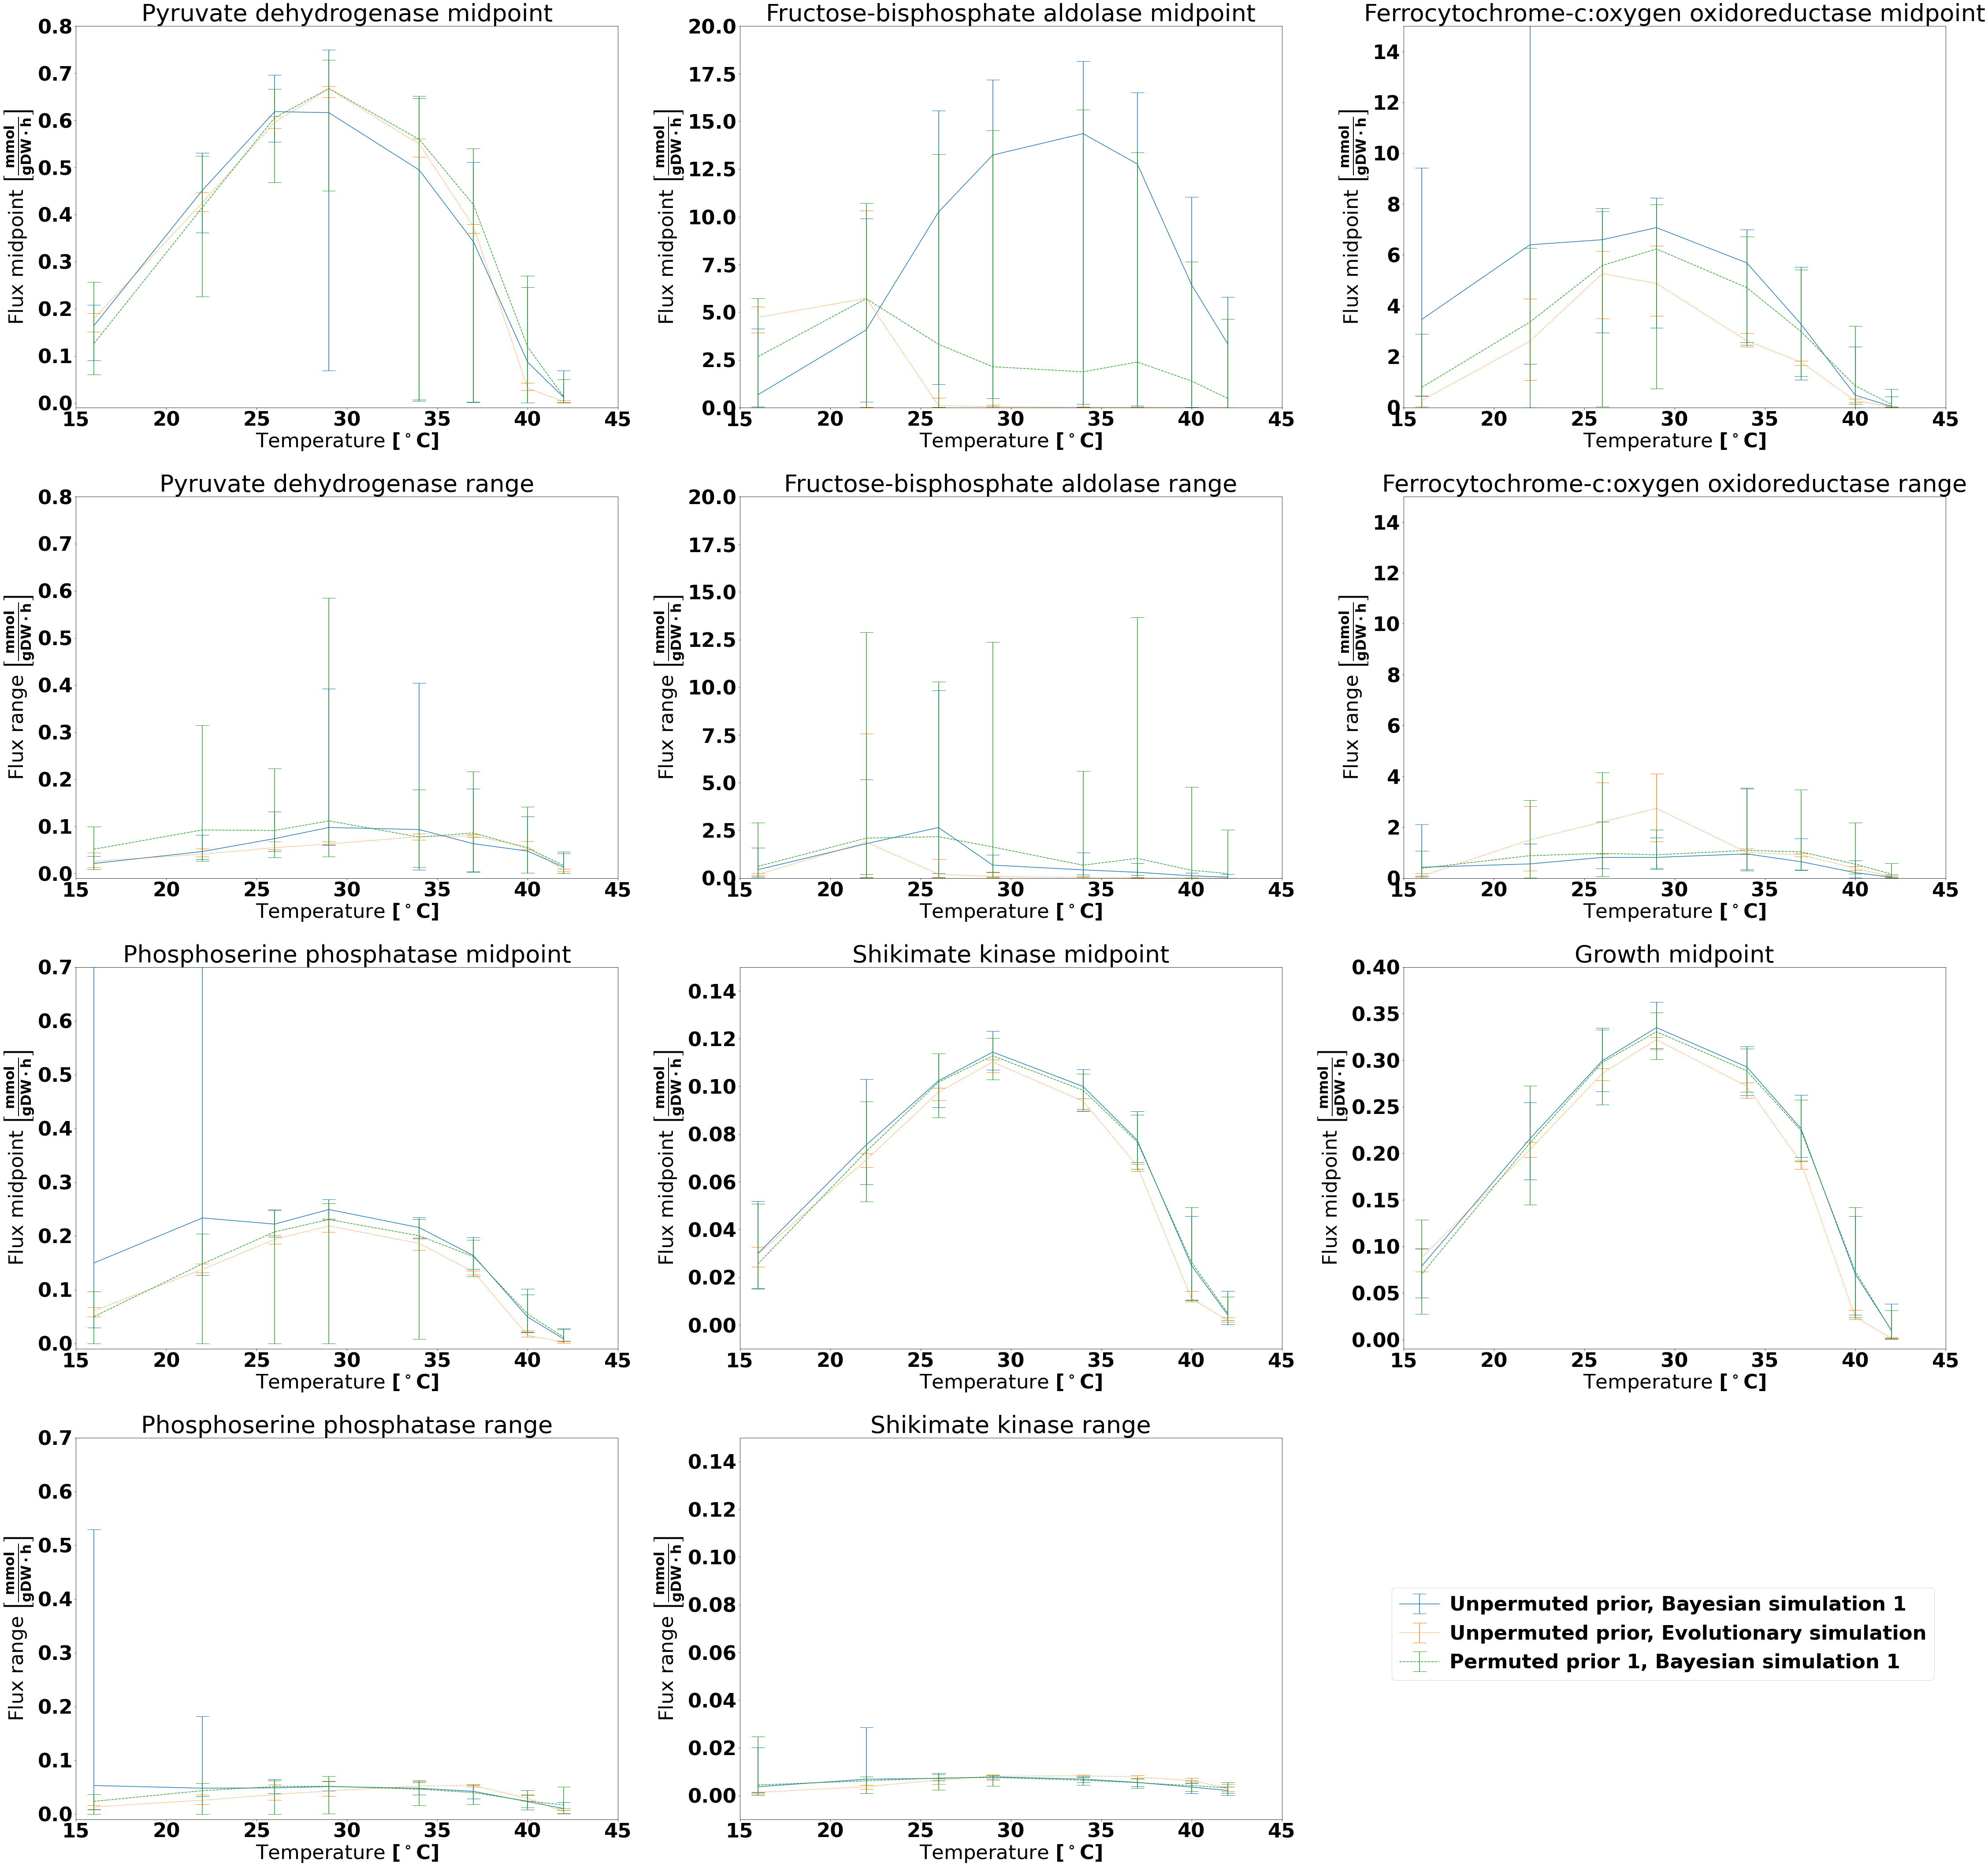

In [277]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Unpermuted prior, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="evolutionary",reaction=reaction, what=what, linestyle="dotted",condition="aerobic",label = "Unpermuted prior, Evolutionary simulation")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="aerobic", label = "Permuted prior 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/aerobic_fva.pdf")

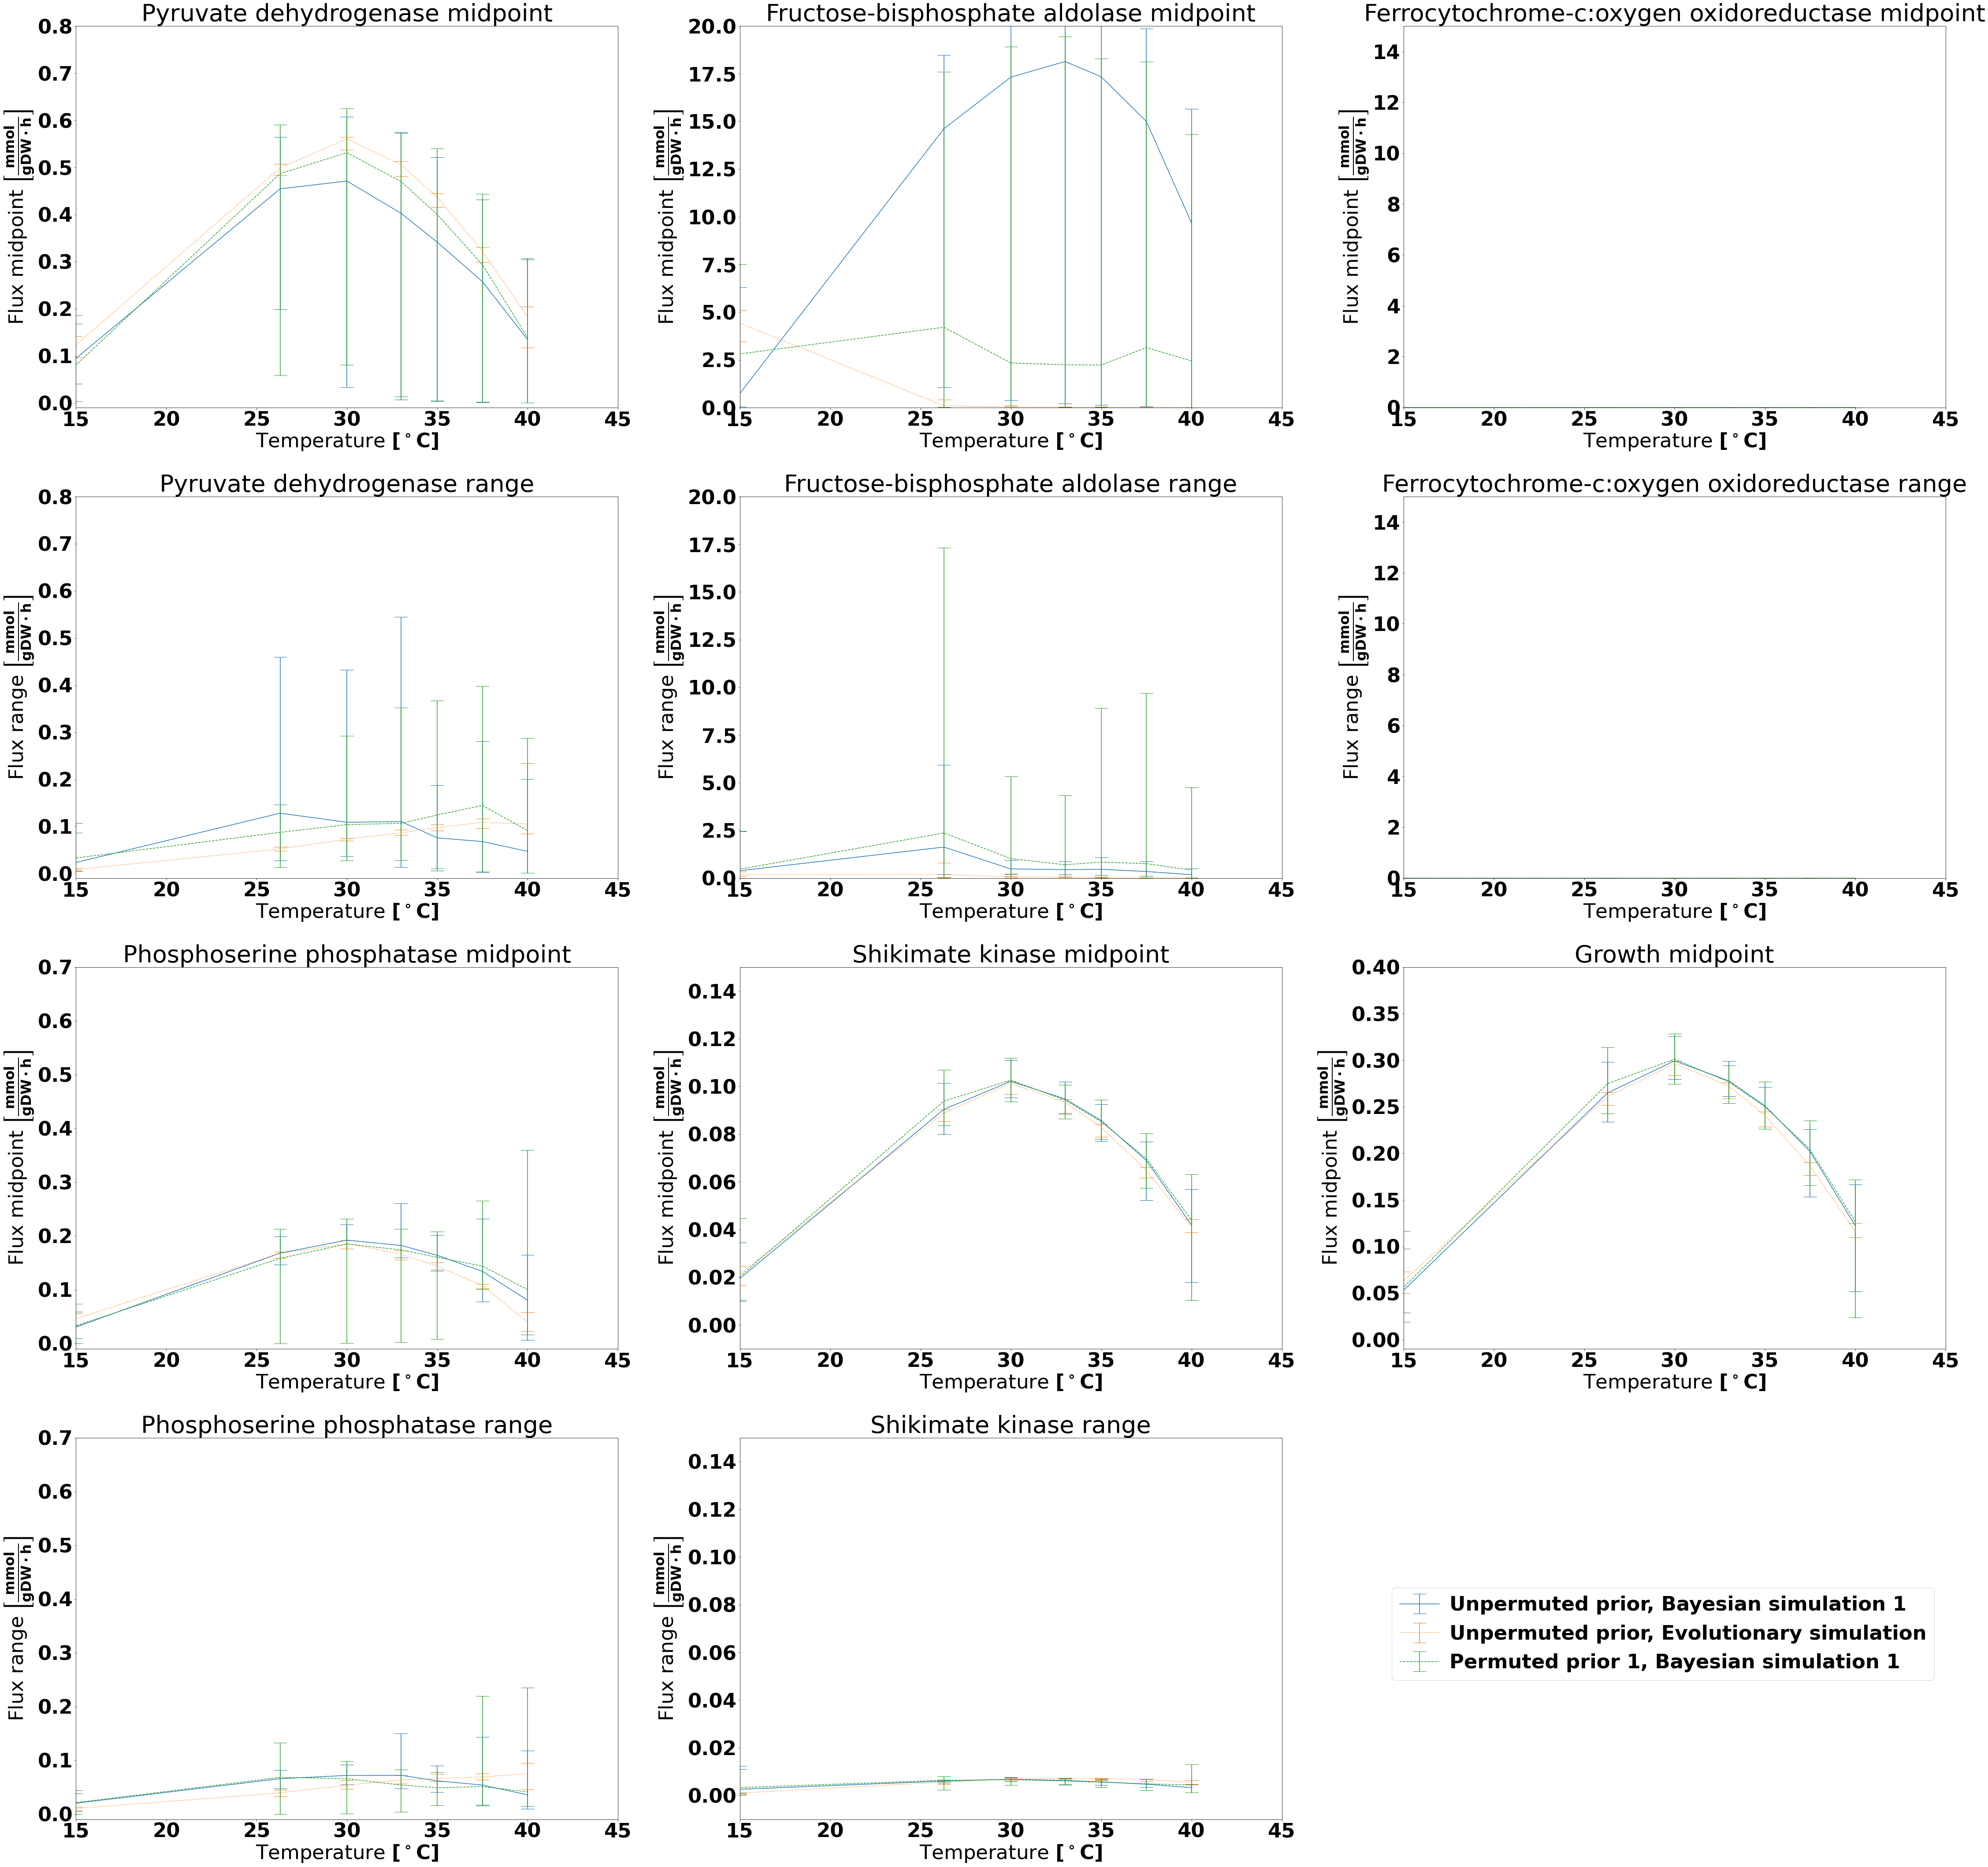

In [276]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="anaerobic", label = "Unpermuted prior, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="evolutionary",reaction=reaction, what=what, linestyle="dotted",condition="anaerobic",label = "Unpermuted prior, Evolutionary simulation")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="anaerobic", label = "Permuted prior 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/anaerobic_fva.pdf")